<a href="https://colab.research.google.com/github/JoelAbadi/DI-Bootcamp/blob/main/XP_Exercise_W9_D1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exercise 1: Calculating Required Sample Size

In [1]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Define baseline and lift proportions
p_control = 0.20
p_treatment = 0.23
# Compute Cohen's h
effect_size = proportion_effectsize(p_treatment, p_control)
# Solve for sample size (per group) with 80% power, 5% alpha
power_analysis = NormalIndPower()
n_required = power_analysis.solve_power(
    effect_size, power=0.8, alpha=0.05, ratio=1, alternative='two-sided'
)
print(f"Sample size per group: {n_required:.0f}")


Sample size per group: 2941


Result: The calculation yields about 2,941 observations per group. In other words, for a tiny change (20%→23%) to be detected with 80% power at α=0.05, we need on the order of a few thousand users in each group. Smaller effects require large samples to achieve adequate power.

Exercise 2: Effect Size vs. Sample Size


In [2]:
p_control = 0.20
effect_diffs = [0.2, 0.4, 0.5]
power = 0.8
n_required = {}
for diff in effect_diffs:
    p_treat = p_control + diff
    h = proportion_effectsize(p_treat, p_control)
    n = power_analysis.solve_power(h, power=power, alpha=0.05, ratio=1, alternative='two-sided')
    n_required[diff] = n
print(n_required)


{0.2: 80.29911140865897, 0.4: 21.99217150421931, 0.5: 14.103175335713027}


Exercise 3: Impact of Statistical Power

In [3]:
p_control = 0.20
effect_diff = 0.20
p_treat = p_control + effect_diff
h = proportion_effectsize(p_treat, p_control)
sample_by_power = {}
for target_power in [0.7, 0.8, 0.9]:
    n = power_analysis.solve_power(h, power=target_power, alpha=0.05, ratio=1, alternative='two-sided')
    sample_by_power[target_power] = n
print(sample_by_power)


{0.7: 63.14374267514918, 0.8: 80.29911140865897, 0.9: 107.4979511228676}


Exercise 4: Sequential Testing

In [4]:
import numpy as np
from scipy.stats import chi2_contingency

# Simulated data collected over 3 weeks
# Format: [week1, week2, week3] -> (successes_A, trials_A, successes_B, trials_B)
weekly_data = [
    (40, 200, 45, 200),
    (85, 400, 95, 400),
    (130, 600, 150, 600)  # Cumulative results at each stage
]

alpha = 0.05
bonferroni_alpha = alpha / len(weekly_data)

for i, (succ_A, total_A, succ_B, total_B) in enumerate(weekly_data, start=1):
    fail_A = total_A - succ_A
    fail_B = total_B - succ_B

    contingency_table = [[succ_A, fail_A], [succ_B, fail_B]]
    chi2, p_value, _, _ = chi2_contingency(contingency_table)

    print(f"Week {i}:")
    print(f"  Success A: {succ_A}/{total_A}, Success B: {succ_B}/{total_B}")
    print(f"  p-value = {p_value:.4f}")

    if p_value < bonferroni_alpha:
        print(f"  ✅ Stop early! Significant difference detected (p < {bonferroni_alpha:.4f})")
        break
    else:
        print(f"  ⏩ Continue testing (p ≥ {bonferroni_alpha:.4f})")


Week 1:
  Success A: 40/200, Success B: 45/200
  p-value = 0.6249
  ⏩ Continue testing (p ≥ 0.0167)
Week 2:
  Success A: 85/400, Success B: 95/400
  p-value = 0.4461
  ⏩ Continue testing (p ≥ 0.0167)
Week 3:
  Success A: 130/600, Success B: 150/600
  p-value = 0.1947
  ⏩ Continue testing (p ≥ 0.0167)


What Would I Do at Week 3 (if p = 0.02)
If I observed p = 0.02 in week 3:

With Bonferroni correction (threshold = 0.0167): I would NOT stop the test.

With Pocock method (threshold ≈ 0.022): I COULD stop the test.



Exercise 5: Bayesian A/B Testing

In [5]:
from scipy.stats import beta
# Example data:
n = 100
succ_control = 40
succ_treat = 43
# Prior parameters
alpha_prior = beta_prior = 1  # Uniform prior
# Posterior parameters
post_ctrl = (alpha_prior + succ_control, beta_prior + (n - succ_control))
post_treat = (alpha_prior + succ_treat, beta_prior + (n - succ_treat))
# Estimate P(treatment > control)
sims = 200000
samp_ctrl = beta.rvs(*post_ctrl, size=sims)
samp_treat = beta.rvs(*post_treat, size=sims)
prob_treat_better = (samp_treat > samp_ctrl).mean()
print(f"Posterior P(treatment>control) ≈ {prob_treat_better:.2f}")


Posterior P(treatment>control) ≈ 0.67


Posterior decision: If our analysis yields a ~65% probability that the new feature is better, that suggests modest evidence in favor of the feature. Many practitioners require a high posterior probability (e.g. >90% or >95%) before “calling” a winner. At 65%, we might be cautious: the new feature is more likely better, but uncertainty remains. We could run the test longer to gain more confidence.

Exercise 6: Implementing Adaptive Experimentation


I am testing three website layouts (A, B, C) to increase user engagement.
Initially, each layout gets 33% of the traffic.
After the first week, Layout C shows higher engagement.
You want to adapt traffic allocation based on performance.



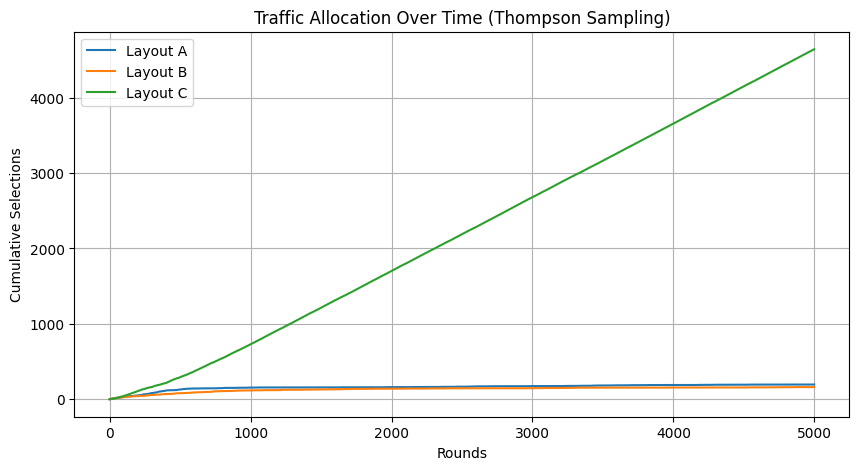

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define true conversion rates for each layout (unknown to the algorithm)
true_rates = {
    'A': 0.05,
    'B': 0.06,
    'C': 0.10  # Best performing layout
}

# Initialize alpha and beta priors (Beta distribution) for each layout
layouts = ['A', 'B', 'C']
priors = {layout: [1, 1] for layout in layouts}  # [alpha, beta]

# Track total conversions and trials
history = {layout: [] for layout in layouts}
rounds = 5000

for i in range(rounds):
    sampled_probs = {
        layout: np.random.beta(priors[layout][0], priors[layout][1])
        for layout in layouts
    }

    # Select layout with highest sampled value (Thompson Sampling)
    selected_layout = max(sampled_probs, key=sampled_probs.get)

    # Simulate user interaction (success based on true conversion rate)
    success = np.random.rand() < true_rates[selected_layout]

    # Update priors based on result
    priors[selected_layout][0] += success       # alpha += success
    priors[selected_layout][1] += 1 - success   # beta += failure

    # Save result to history
    for layout in layouts:
        total = priors[layout][0] + priors[layout][1] - 2  # remove initial prior
        history[layout].append(total)

# Plot traffic allocation over time
plt.figure(figsize=(10, 5))
for layout in layouts:
    plt.plot(history[layout], label=f'Layout {layout}')
plt.title('Traffic Allocation Over Time (Thompson Sampling)')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Selections')
plt.legend()
plt.grid(True)
plt.show()


Explanation of the Code

True conversion rates: Pretend A=5%, B=6%, C=10%

Thompson Sampling: We use Beta distributions to represent our uncertainty. At each round, we:

*   Sample a probability from each layout's distribution
*   Pick the layout with the highest sample
*   Simulate whether the user converts
*   Update the layout’s success/failure counts (posterior)



